In [1]:
import os
import time
import pickle
import warnings
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
sns.set_theme()

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score, f1_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
pd.set_option('display.colheader_justify', 'center')

### Helper functions
Functions intended to declutter cells in the notebook

In [2]:
randomState = 42
url='Datasets/diabetes_dataset.csv'

def getData(url = url):

    url = url
    df = pd.read_csv(url)
    return df

def cleanData(url = url):

    #Drop duplicates
    print('Dropping duplicates...\n')
    df.drop_duplicates(inplace=True)
    time.sleep(1)

    #Change all column names to lower case
    print('Converting to lower case columns and data...')
    df.columns = df.columns.str.replace('Diabetes_binary','diabetes').str.lower()

    #This next for loop doesn't get executed because there are no "object" type columns
    for col in df.select_dtypes(object).columns:
        df[col] = df[col].str.lower().str.replace(' ', '_')

    time.sleep(1)

    return df

def splitData(df):

    target = df.diabetes
    data = df.drop(columns=['diabetes'])
    dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, target, test_size=0.2, random_state=randomState)
    dfTrain, dfVal, yTrain, yVal = train_test_split(dfTrainFull, yTrainFull, test_size=0.25, random_state=randomState)

    print(  f'Dataset has been split in: Training set with {len(yTrain)} samples, '
            f'Validation set with {len(yVal)} samples and Test set with {len(yTest)} samples')

    return dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest

def printHelper(f1Score, auc):
    
    print('\n---------------------------------')
    print(f'Test set weighted f1-score: {f1Score}')
    print(f'Test set auc: {auc}')
    print('---------------------------------\n')

def printResults(results):  
    print('\n-----------------------------------------')
    for i,j in results.items():
        print('{:<20}:  {:<6}'.format(i, " ± ".join([str(x) for x in j])))
    print('-----------------------------------------')

    
def getMeasures(model):

    yTestpredProb = model.predict_proba(dfTest)[:,1]
    yTestpred = model.predict(dfTest)
    auc = round(roc_auc_score(yTest, yTestpredProb),3)
    f1Score = round(f1_score(yTest, yTestpred, average='weighted'),3)
    modelName = type(model.named_steps.classifier).__name__

    printHelper(f1Score, auc)

    print(classification_report(yTest, yTestpred))

    fig1, ax1 = plt.subplots(figsize=(9, 5))
    fpr, tpr, _ = roc_curve(yTest.values, yTestpredProb)
    roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, name=f'ROC_AUC {modelName}', )
    ax1.text(0.4,0.5,f'AUC = {auc}', size=14, fontweight='semibold', )
    ax1.text(0.4,0.4,f'Weighted F1  = {f1Score}', size=14, fontweight='semibold')
    ax1.legend(loc=4, prop={'size': 20})
    fig1.tight_layout()
    print()

    fig2, axs2 = plt.subplots(1,2, figsize=(9, 5))

    cm = confusion_matrix(yTest, yTestpred)
    cmprob = confusion_matrix(yTest, yTestpred, normalize='true')
    cm_display1 = ConfusionMatrixDisplay(cm, display_labels=['No-Diabetes', 'Diabetes'])
    cm_display2 = ConfusionMatrixDisplay(cmprob, display_labels=['No-Diabetes', 'Diabetes'])
    cms = {'Confusion Matrix': cm, 'Confusion Matrix Normalized': cmprob}

    for (name,matrix), ax in zip(cms.items(), axs2.ravel()):
        cm_display = ConfusionMatrixDisplay(cm, display_labels=['No-Diabetes', 'Diabetes'])
        cm_display.plot(ax=ax)
        ax.grid(False)
        cm_display.ax_.set_title(name, size=12)

    fig2.tight_layout()
    plt.show()    

    rtn = {}
    rtn['test_roc_auc'] = [auc]
    rtn['test_f1-score'] = [f1Score]
    
    return rtn, cmprob

def getResults(model, params):
    
    baseParams = ["mean_train_auc",
                  "std_train_auc",
                  "rank_test_auc",
                  "mean_train_f1_weighted",
                  "std_train_f1_weighted",
                  "rank_test_f1_weighted"
    ]
    
    allParams = baseParams + params
    
    cv_results = pd.DataFrame(model.cv_results_)

    res = cv_results[allParams]
    
    if 'param_classifier__reg_lambda' not in params:
        display(res.query('rank_test_auc < 30 & rank_test_f1_weighted < 30').sort_values(by=["rank_test_auc", "rank_test_f1_weighted"]))
    else:
        display(res.sort_values(by=["rank_test_auc", "rank_test_f1_weighted"]).head(20))

def getBestModelResults(model):
    
    cv_results = cross_validate(model,
                                dfTrainFull,
                                yTrainFull,
                                cv=outerCV,
                                scoring=['f1_weighted','roc_auc'],
                                n_jobs=-1,
                                return_train_score=True,
                                return_estimator=True,
    )

    cv_results = pd.DataFrame(cv_results)
    cv_test_scores = cv_results[['test_f1_weighted', 'train_f1_weighted', 'test_roc_auc', 'train_roc_auc']]
    cv_test_scores.columns = ['val_f1_weighted', 'val_roc_auc','train_f1_weighted', 'train_roc_auc']
    
    print("Scores after hyperparameters tuning:\n")
    
    res = cv_test_scores.copy()
    res.loc['mean'] = res.mean().round(4)
    res.loc['std'] = res.std().round(4)
    
    rtn = {}
    for col in res:
        print('{:<20}:  {:<6} +/- {:<6}'.format(col, res.loc["mean"][col], res.loc["std"][col]))
        rtn[col] = [res.loc["mean"][col], res.loc["std"][col]]
    
    return rtn

### Load binary unbalanced data

In [3]:
df = getData()
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


## EDA

#### Preparing and cleaning data
See function def cleanData(url = url)<br>Dropping duplicated values, converting column names and data to lower case and replacing blanks with '_'.

In [4]:
df = cleanData(df)
df

Dropping duplicates...

Converting to lower case columns and data...


,diabetes,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


#### Checking missing values
There are no missing values

In [5]:
df.isnull().sum()

diabetes                0
highbp                  0
highchol                0
cholcheck               0
bmi                     0
smoker                  0
stroke                  0
heartdiseaseorattack    0
physactivity            0
fruits                  0
veggies                 0
hvyalcoholconsump       0
anyhealthcare           0
nodocbccost             0
genhlth                 0
menthlth                0
physhlth                0
diffwalk                0
sex                     0
age                     0
education               0
income                  0
dtype: int64

#### Checking type of data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229474 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   diabetes              229474 non-null  int64
 1   highbp                229474 non-null  int64
 2   highchol              229474 non-null  int64
 3   cholcheck             229474 non-null  int64
 4   bmi                   229474 non-null  int64
 5   smoker                229474 non-null  int64
 6   stroke                229474 non-null  int64
 7   heartdiseaseorattack  229474 non-null  int64
 8   physactivity          229474 non-null  int64
 9   fruits                229474 non-null  int64
 10  veggies               229474 non-null  int64
 11  hvyalcoholconsump     229474 non-null  int64
 12  anyhealthcare         229474 non-null  int64
 13  nodocbccost           229474 non-null  int64
 14  genhlth               229474 non-null  int64
 15  menthlth              229474 non-n

#### Checking feature and target value distributions
Most of the features are categorical (binary), some others are numerical.  The target value is heavily imbalanced.  No Diabetes- 194377, Diabetes- 35097.

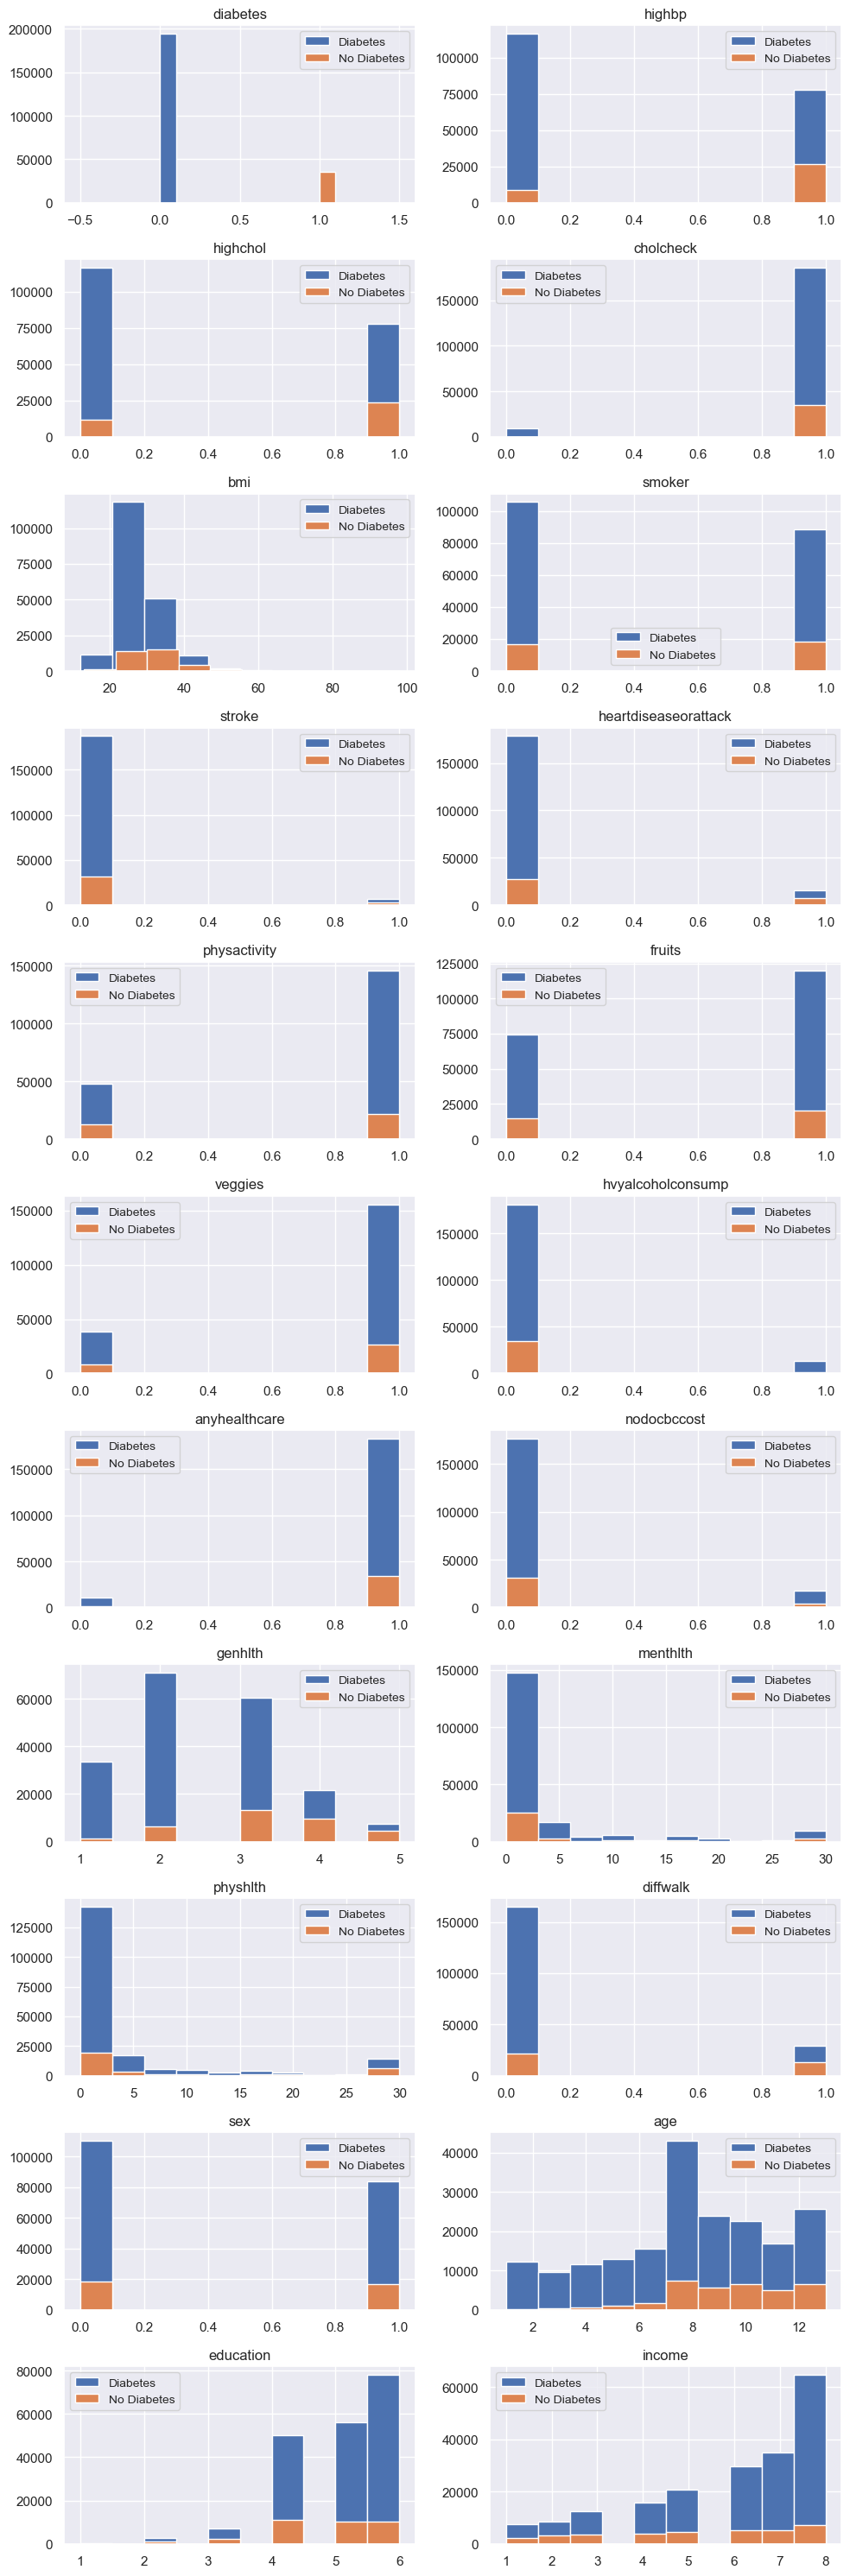

In [7]:
diabetes0 = df[df.diabetes==0]
diabetes1 = df[df.diabetes==1]

columns = df.columns
idxs = list(product(range(0,11), range(0,2)))

fig, axs = plt.subplots(11,2, figsize=(10, 30))
for col,ax in zip(columns, axs.ravel()):
    ax.hist(diabetes0[col], stacked=True, label='Diabetes')
    ax.hist(diabetes1[col], stacked=True, label='No Diabetes')
    ax.legend(prop={'size': 10})
    ax.set_title(col)

fig.tight_layout()
plt.show()

#### Checking Correlations among all features including target

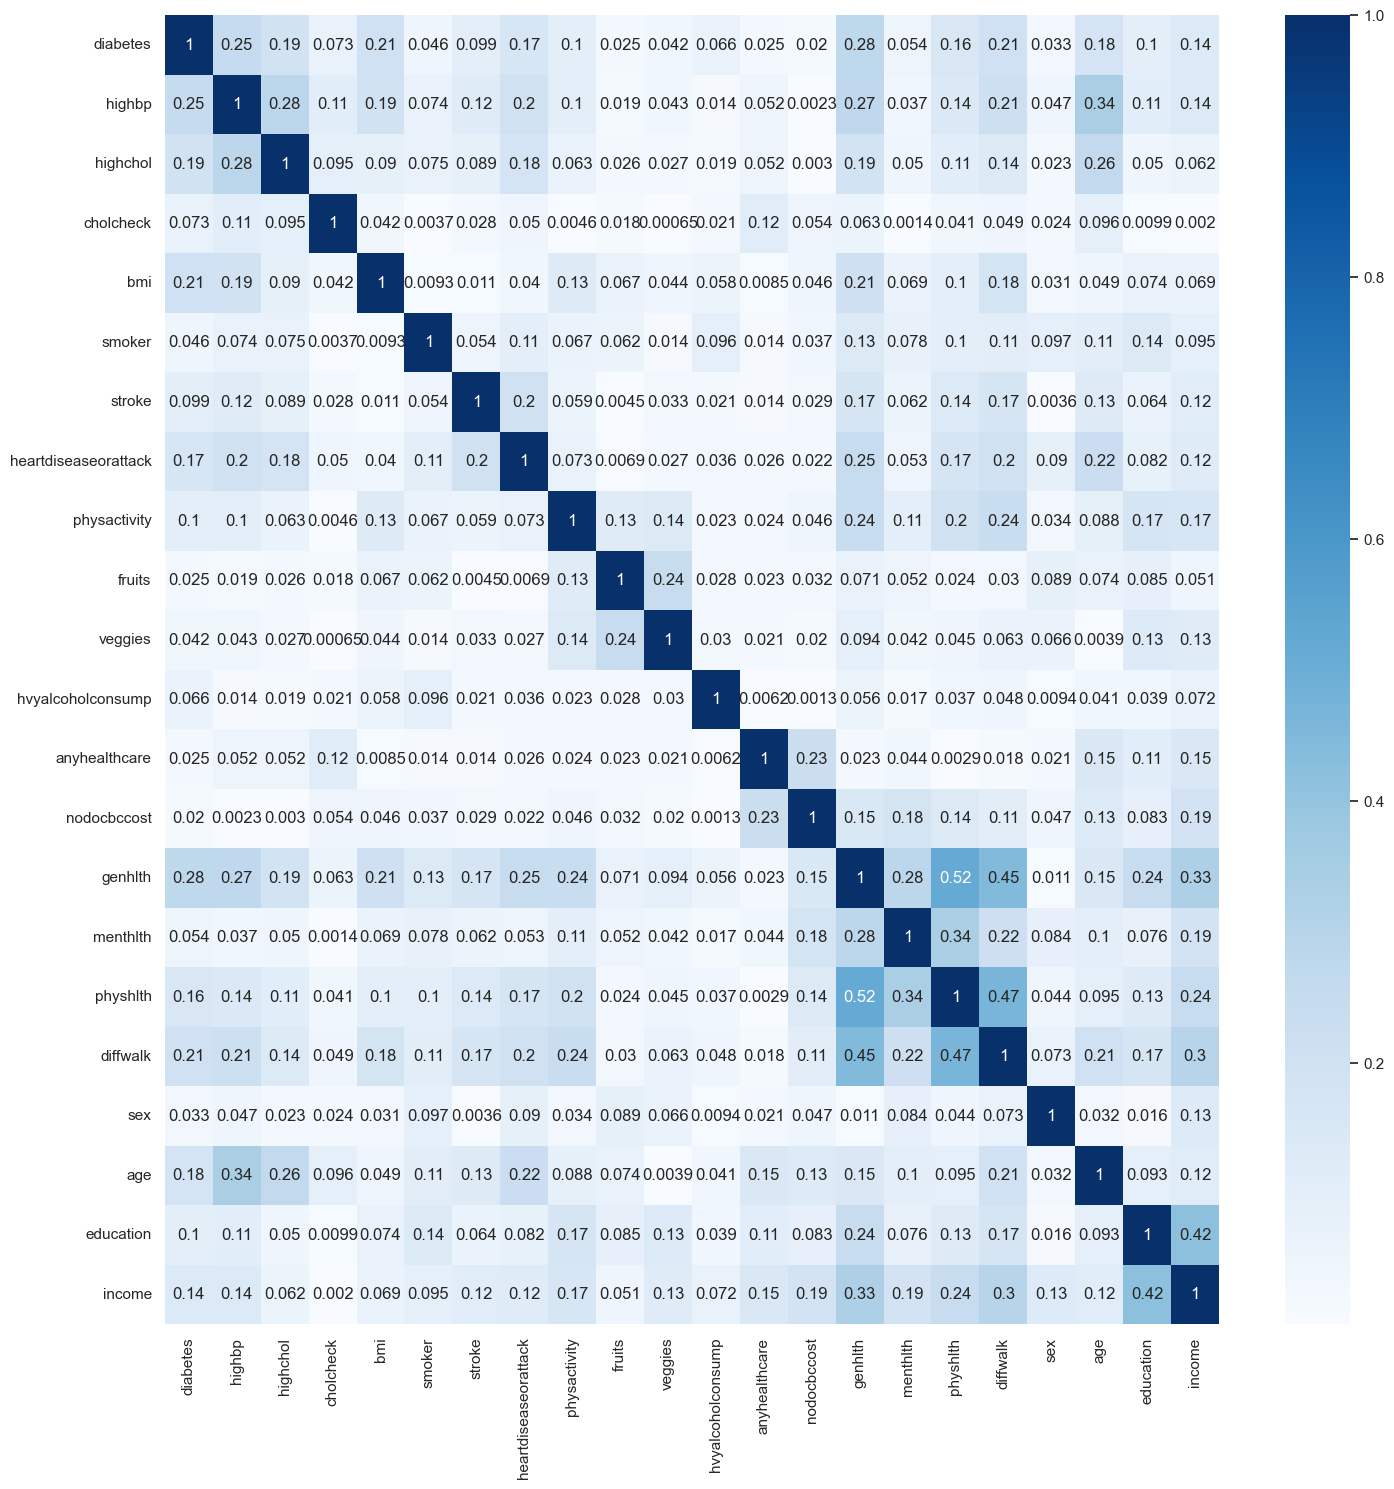

In [8]:
sns.set_theme()
corr_matrix = df.corr().abs()
plt.figure(figsize=(17,17))

_ = sns.heatmap(corr_matrix, cmap="Blues", annot=True)

#### Checking correlation against target variable 'diabetes'

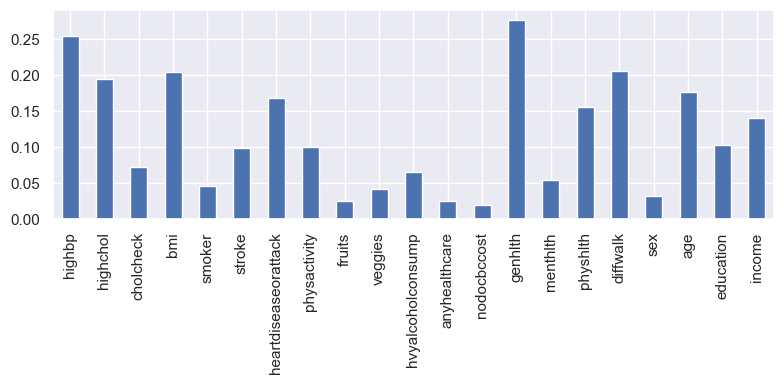

In [9]:
dfMatrix = df.drop(columns='diabetes')
corr_matrix = dfMatrix.corrwith(df.diabetes).abs()
fig,ax = plt.subplots(1,1)
_ = corr_matrix.plot(kind='bar', grid=True, ax=ax, figsize=(8,4))
fig.tight_layout()
_ = plt.show()  

In [10]:
corr_matrix.sort_values(ascending=False)

genhlth                 0.276940
highbp                  0.254318
diffwalk                0.205302
bmi                     0.205086
highchol                0.194944
age                     0.177263
heartdiseaseorattack    0.168213
physhlth                0.156211
income                  0.140659
education               0.102686
physactivity            0.100404
stroke                  0.099193
cholcheck               0.072523
hvyalcoholconsump       0.065950
menthlth                0.054153
smoker                  0.045504
veggies                 0.041734
sex                     0.032724
anyhealthcare           0.025331
fruits                  0.024805
nodocbccost             0.020048
dtype: float64

#### Dropping parameters with lower correlation

In [11]:
df.drop(columns=['nodocbccost', 'fruits', 'anyhealthcare', 'veggies'], inplace=True)

#### Splitting data

In [12]:
dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest = splitData(df)

Dataset has been split in: Training set with 137684 samples, Validation set with 45895 samples and Test set with 45895 samples


#### Preprocessing

This part will be used for the Logistic Regression classifier only

In [13]:
categoricalCols = ['highbp', 'highchol', 'cholcheck','smoker','stroke',
                   'heartdiseaseorattack', 'physactivity', 'hvyalcoholconsump',
                   'genhlth','diffwalk', 'sex', 'education', 'income']

numericalCols = ['bmi', 'menthlth', 'physhlth']

In [14]:
# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")

## ML Models

#### Setting up inner and outter crossvalidation KFolds

In [15]:
# Inner cross-validation(for Hyperparameter tuning)
innerCV = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)
# Outer cross-validation(for testing the tunned model)
outerCV = StratifiedKFold(n_splits=3, shuffle=True, random_state=randomState)

#### Metrics to be used ROC AUC and F1 Score

In [16]:
scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}
confusion_matrices = {}

### DecisionTreeClassifier

#### Will use nested CrossValidation

inner cross-validation(for Hyperparameter tuning)

In [17]:
# Model
model_DT = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced', random_state = randomState))])

# Gridsearch - Hyperparameters tunning

param_grid = {
    'classifier__max_depth': (1,3,5,7,10),
    'classifier__max_leaf_nodes': (1, 5,10,15,20),
    'classifier__max_features': (1,3,5,7,10,15)
}

model_grid_search_DT = GridSearchCV(model_DT,
                                    param_grid=param_grid,
                                    scoring=scoring,
                                    n_jobs=-1,
                                    cv=innerCV,
                                    return_train_score=True,
                                    refit=False)

_ = model_grid_search_DT.fit(dfTrainFull, yTrainFull)

In [18]:
paramsDT = ["param_classifier__max_depth",
            'param_classifier__max_leaf_nodes',
            "param_classifier__max_features"]

getResults(model_grid_search_DT, paramsDT)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features
89,0.785094,0.000679,1,0.736637,0.011232,21,5,20,15
119,0.785204,0.000760,2,0.753910,0.005530,11,7,20,15
149,0.785204,0.000760,2,0.753910,0.005530,11,10,20,15
114,0.783854,0.000769,4,0.735087,0.011630,22,7,20,10
144,0.783854,0.000769,4,0.735087,0.011630,22,10,20,10
84,0.783589,0.000436,6,0.738683,0.009052,16,5,20,10
88,0.780232,0.000794,7,0.732379,0.014683,27,5,15,15
118,0.780232,0.000794,7,0.732379,0.014683,27,7,15,15
148,0.780232,0.000794,7,0.732379,0.014683,27,10,15,15
87,0.770915,0.000649,13,0.733105,0.010321,24,5,10,15


#### Selecting best parameters
We will choose max_depth=7, max_leaf_nodes=20 and max_features=15. Reaching a compromise between F1 Score and AUC.

In [19]:
bestParamsDT = ['max_depth=7', 'max_leaf_nodes=20', 'max_features=5']

modelDT = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced',
                                                        random_state = randomState,
                                                        max_depth=7,
                                                        max_leaf_nodes=20,
                                                        max_features=15))])

_ = modelDT.fit(dfTrainFull, yTrainFull)

Outer cross-validation(for testing the tunned model)

In [20]:
results = {}
results = getBestModelResults(modelDT)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.744  +/- 0.0132
val_roc_auc         :  0.7442 +/- 0.0136
train_f1_weighted   :  0.7834 +/- 0.0004
train_roc_auc       :  0.785  +/- 0.0008


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.737
Test set auc: 0.783
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.69      0.79     38813
           1       0.30      0.75      0.43      7082

    accuracy                           0.70     45895
   macro avg       0.62      0.72      0.61     45895
weighted avg       0.84      0.70      0.74     45895




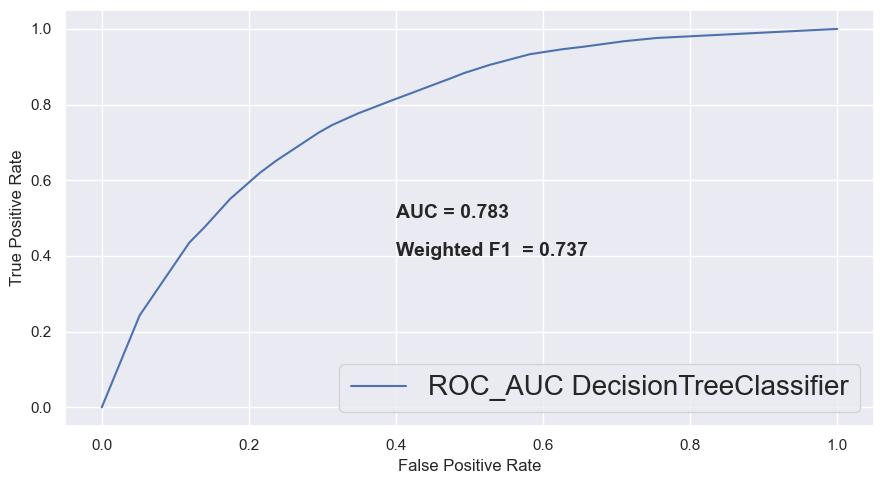

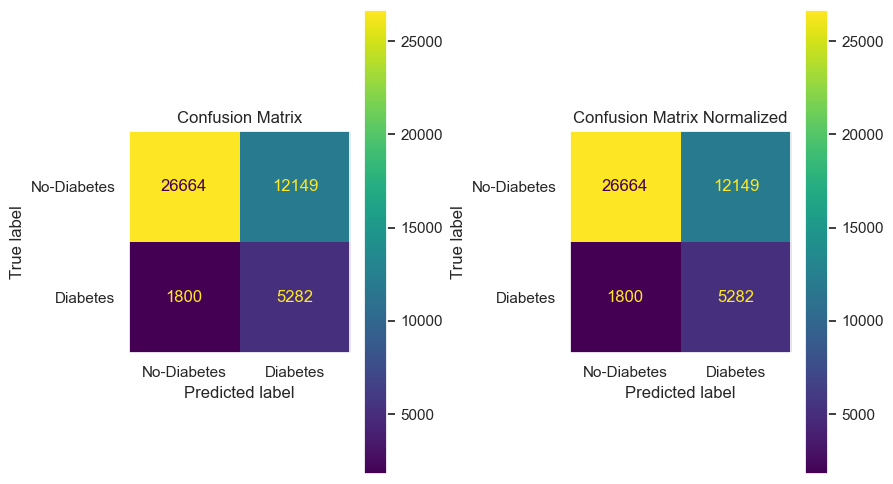

In [21]:
rtn, cm = getMeasures(modelDT)
results.update(rtn)
confusion_matrices.update({'Desicion Tree' : cm})

### DecisionTreeClassifier results:

In [22]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.744 ± 0.0132
val_roc_auc         :  0.7442 ± 0.0136
train_f1_weighted   :  0.7834 ± 0.0004
train_roc_auc       :  0.785 ± 0.0008
test_roc_auc        :  0.783 
test_f1-score       :  0.737 
-----------------------------------------


### Logistic Regression

In [23]:
model_LR = Pipeline([("processor", preprocessor),
                  ("classifier", LogisticRegression(max_iter=1000,
                                                    class_weight='balanced',
                                                    random_state=randomState))])

# Gridsearch - Hyperparameters tunning

param_grid = {
    'classifier__C': (1e-3, 1e-2, 0.1, 1, 5, 10, 20),
}

model_grid_search_LR = GridSearchCV(model_LR,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 refit=False)
_ = model_grid_search_LR.fit(dfTrainFull, yTrainFull)

In [24]:
paramsLR = ["param_classifier__C"]

getResults(model_grid_search_LR, paramsLR)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__C
1,0.807610,0.000652,1,0.753739,0.000755,2,0.01
2,0.807562,0.000654,2,0.753479,0.000717,5,0.1
5,0.807551,0.000654,3,0.753462,0.000690,7,10
3,0.807551,0.000652,4,0.753488,0.000694,3,1
6,0.807550,0.000654,5,0.753454,0.000707,4,20
4,0.807549,0.000657,6,0.753451,0.000738,6,5
0,0.806354,0.000641,7,0.754026,0.000514,1,0.001


#### Selecting best parameters
Choosing C=0.01, in this case it's the beast AUC and 2nd best F1 Score

In [25]:
modelLR = Pipeline([("classifier", LogisticRegression(max_iter=1000,
                                                    C=0.01,
                                                    class_weight='balanced',
                                                    random_state=randomState))])

_ = modelLR.fit(dfTrainFull, yTrainFull)

Outer cross-validation(for testing the tunned model)

In [26]:
results = {}
results = getBestModelResults(modelLR)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7555 +/- 0.0008
val_roc_auc         :  0.7555 +/- 0.0007
train_f1_weighted   :  0.8071 +/- 0.0014
train_roc_auc       :  0.8072 +/- 0.0007


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.756
Test set auc: 0.809
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     38813
           1       0.32      0.75      0.45      7082

    accuracy                           0.72     45895
   macro avg       0.63      0.73      0.63     45895
weighted avg       0.85      0.72      0.76     45895




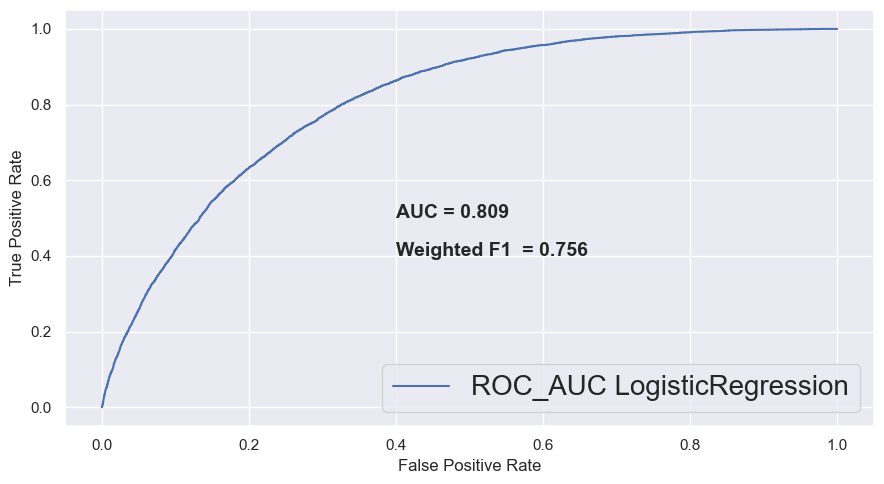

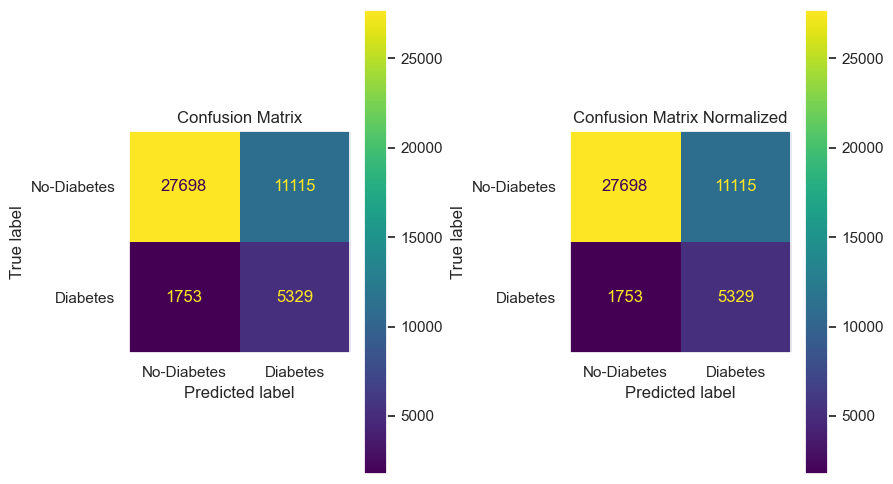

In [27]:
rtn, cm = getMeasures(modelLR)
results.update(rtn)
confusion_matrices.update({'Logistic Regression' : cm})

### Logistic Regression results:

In [28]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7555 ± 0.0008
val_roc_auc         :  0.7555 ± 0.0007
train_f1_weighted   :  0.8071 ± 0.0014
train_roc_auc       :  0.8072 ± 0.0007
test_roc_auc        :  0.809 
test_f1-score       :  0.756 
-----------------------------------------


### Random Forest

In [29]:
model_RF = Pipeline([("classifier", RandomForestClassifier(n_estimators=10,
                                                           class_weight='balanced',
                                                           random_state=randomState))])

# Gridsearch - Hyperparameters tunning

param_grid = {
    'classifier__max_depth': (5,10,15,20,25),
    'classifier__max_leaf_nodes': (5,10,15,20,30),
    'classifier__max_features': (3,5,7,10)
}

model_grid_search_RF = GridSearchCV(model_RF,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 refit=False)
_ = model_grid_search_RF.fit(dfTrainFull, yTrainFull)

In [30]:
paramsRF = ["param_classifier__max_depth",
            'param_classifier__max_leaf_nodes',
            "param_classifier__max_features"]

getResults(model_grid_search_RF, paramsRF)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features
29,0.802340,0.000626,5,0.744041,0.004599,6,10,30,5
49,0.802340,0.000626,5,0.744041,0.004599,6,15,30,5
69,0.802340,0.000626,5,0.744041,0.004599,6,20,30,5
89,0.802340,0.000626,5,0.744041,0.004599,6,25,30,5
39,0.801733,0.000766,9,0.742631,0.004675,11,10,30,10
59,0.801733,0.000766,9,0.742631,0.004675,11,15,30,10
79,0.801733,0.000766,9,0.742631,0.004675,11,20,30,10
99,0.801733,0.000766,9,0.742631,0.004675,11,25,30,10
34,0.801186,0.000974,13,0.741562,0.004339,21,10,30,7
54,0.801186,0.000974,13,0.741562,0.004339,21,15,30,7


#### Selecting best parameters
Choosing max_depth = 10, max_leaf_nodes=30 and max_features=5.

In [31]:
modelRF = Pipeline([("classifier", RandomForestClassifier(n_estimators=10,
                                                          max_depth = 10,
                                                          max_leaf_nodes=30,
                                                          max_features=5,
                                                          class_weight='balanced',
                                                          random_state=randomState))])

_ = modelRF.fit(dfTrainFull, yTrainFull)

Outer cross-validation(for testing the tuned model)

In [32]:
results = {}
results = getBestModelResults(modelRF)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7464 +/- 0.0081
val_roc_auc         :  0.7471 +/- 0.0085
train_f1_weighted   :  0.8009 +/- 0.001 
train_roc_auc       :  0.8029 +/- 0.0009


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.748
Test set auc: 0.801
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.70      0.80     38813
           1       0.31      0.75      0.44      7082

    accuracy                           0.71     45895
   macro avg       0.63      0.73      0.62     45895
weighted avg       0.84      0.71      0.75     45895




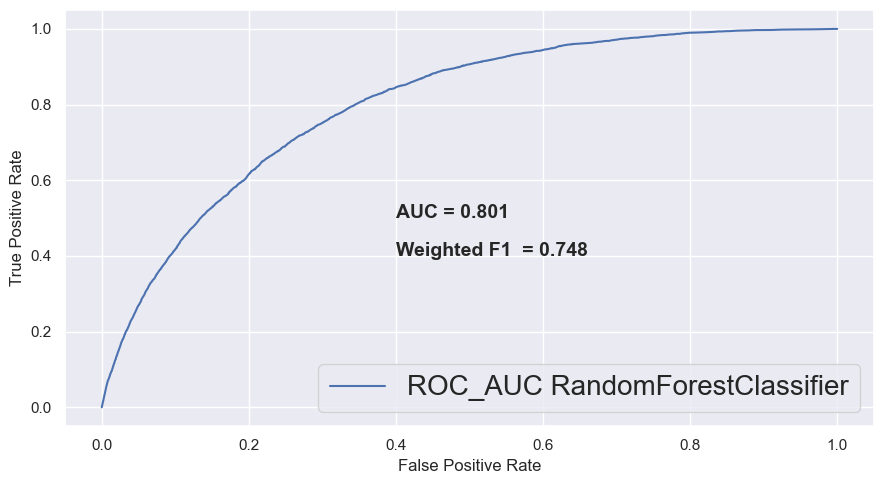

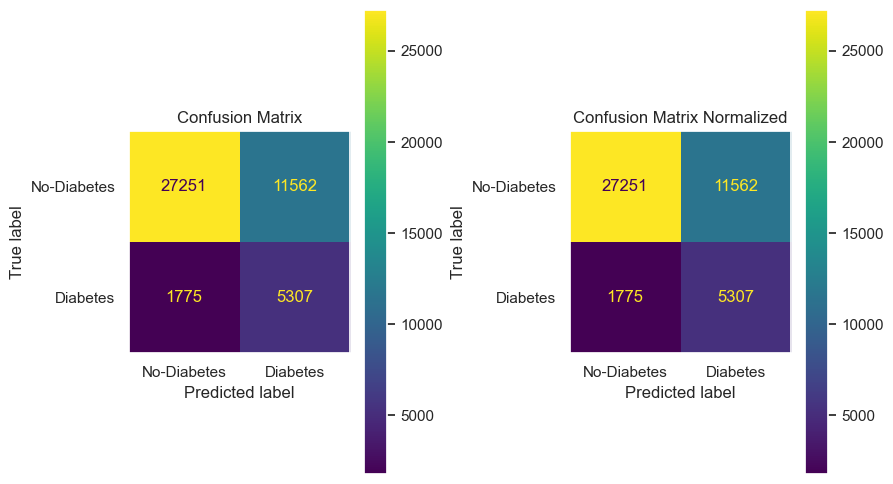

In [33]:
rtn, cm = getMeasures(modelRF)
results.update(rtn)
confusion_matrices.update({'Random Forest' : cm})

### Random Forest results:

In [34]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7464 ± 0.0081
val_roc_auc         :  0.7471 ± 0.0085
train_f1_weighted   :  0.8009 ± 0.001
train_roc_auc       :  0.8029 ± 0.0009
test_roc_auc        :  0.801 
test_f1-score       :  0.748 
-----------------------------------------


### XGBoost Classifier

In [35]:
imbalanceRatio = (yTrainFull==0).sum() / (yTrainFull==1).sum()
imbalanceRatio = round(imbalanceRatio, 2)
imbalanceRatio

5.55

In [36]:
# Inner cross-validation(for Hyperparameter tuning)
innerCV = StratifiedKFold(n_splits=3, shuffle=True, random_state=randomState)

model_XGB = Pipeline([("classifier", XGBClassifier(n_estimators=10,
                                                   random_state=randomState, 
                                                   #tree_method='gpu_hist',
                                                   scale_pos_weight=imbalanceRatio)
                      )])

# Gridsearch - Hyperparameters tunning

param_grid = {
    'classifier__max_depth' : (2, 5, 8, 10),
    'classifier__learning_rate' : (0.01, 0.1, 0.5, 0.8),
    'classifier__min_child_weight' : (1,10,20),
    'classifier__reg_lambda' : (1, 3, 5, 8),
}

model_grid_search_XGB = GridSearchCV(model_XGB,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 verbose=4,                                 
                                 refit=False)

_ = model_grid_search_XGB.fit(dfTrain, yTrain)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [37]:
paramsXGB = ["param_classifier__max_depth",
             'param_classifier__learning_rate',
             "param_classifier__min_child_weight",
             "param_classifier__reg_lambda"]

getResults(model_grid_search_XGB, paramsXGB)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__learning_rate,param_classifier__min_child_weight,param_classifier__reg_lambda
110,0.819318,0.000910,1,0.748177,0.001001,120,5,0.5,1,5
109,0.819562,0.000758,2,0.749011,0.001508,111,5,0.5,1,3
117,0.818776,0.001081,3,0.749180,0.000556,107,5,0.5,20,3
113,0.819135,0.001349,4,0.748109,0.002220,122,5,0.5,10,3
119,0.818960,0.001030,5,0.748913,0.001191,102,5,0.5,20,8
114,0.819190,0.000935,6,0.749842,0.000590,97,5,0.5,10,5
115,0.819066,0.000818,7,0.749303,0.001111,100,5,0.5,10,8
111,0.819470,0.000989,8,0.749014,0.001199,105,5,0.5,1,8
118,0.818636,0.000964,9,0.748317,0.000990,113,5,0.5,20,5
108,0.819537,0.001182,10,0.749239,0.000622,112,5,0.5,1,1


#### Selecting best parameters
Choosing max_depth = 8, learning_rate = 0.5, min_child_weight = 20 and reg_lambda = 8,. It's a good compromise between a good AUC and F1 Score.

In [38]:
modelXGB = Pipeline([("classifier", XGBClassifier(n_estimators = 10,
                                                  max_depth = 8,
                                                  learning_rate = 0.5,
                                                  min_child_weight = 20,
                                                  reg_lambda = 8,
                                                  random_state=randomState, 
                                                  #tree_method='gpu_hist',
                                                  scale_pos_weight=imbalanceRatio                                                  
                                                 ))
                    ])

_ = modelXGB.fit(dfTrainFull, yTrainFull)

Outer cross-validation(for testing the tuned model)

In [39]:
results = {}
results = getBestModelResults(modelXGB)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7508 +/- 0.0039
val_roc_auc         :  0.7591 +/- 0.004 
train_f1_weighted   :  0.8112 +/- 0.001 
train_roc_auc       :  0.834  +/- 0.0011


#### Curves and measures of error


---------------------------------
Test set weighted f1-score: 0.752
Test set auc: 0.813
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.70      0.81     38813
           1       0.32      0.77      0.45      7082

    accuracy                           0.71     45895
   macro avg       0.63      0.74      0.63     45895
weighted avg       0.85      0.71      0.75     45895




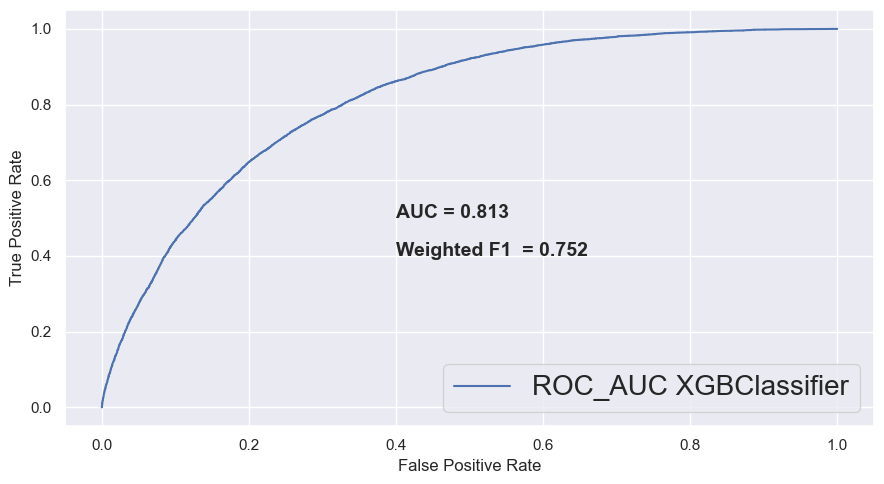

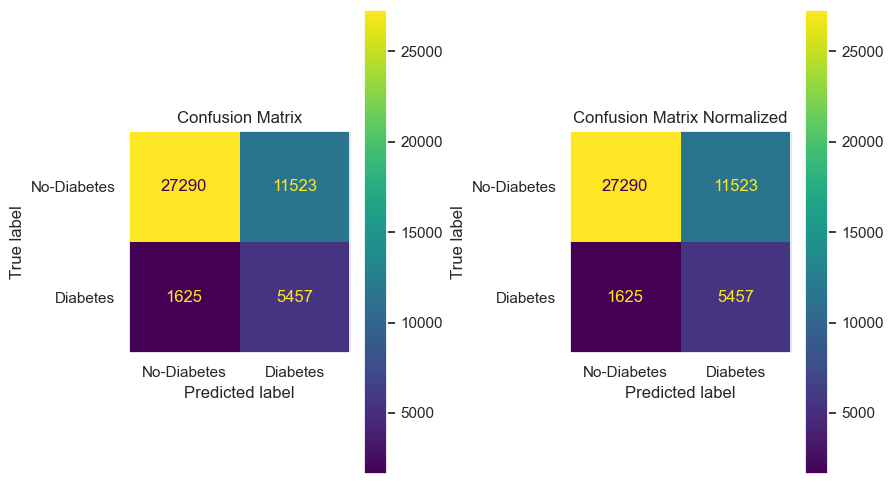

In [40]:
rtn, cm = getMeasures(modelXGB)
results.update(rtn)
confusion_matrices.update({'XGBoost' : cm})

### XGBoost results:

In [41]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7508 ± 0.0039
val_roc_auc         :  0.7591 ± 0.004
train_f1_weighted   :  0.8112 ± 0.001
train_roc_auc       :  0.834 ± 0.0011
test_roc_auc        :  0.813 
test_f1-score       :  0.752 
-----------------------------------------


## Comparing models results

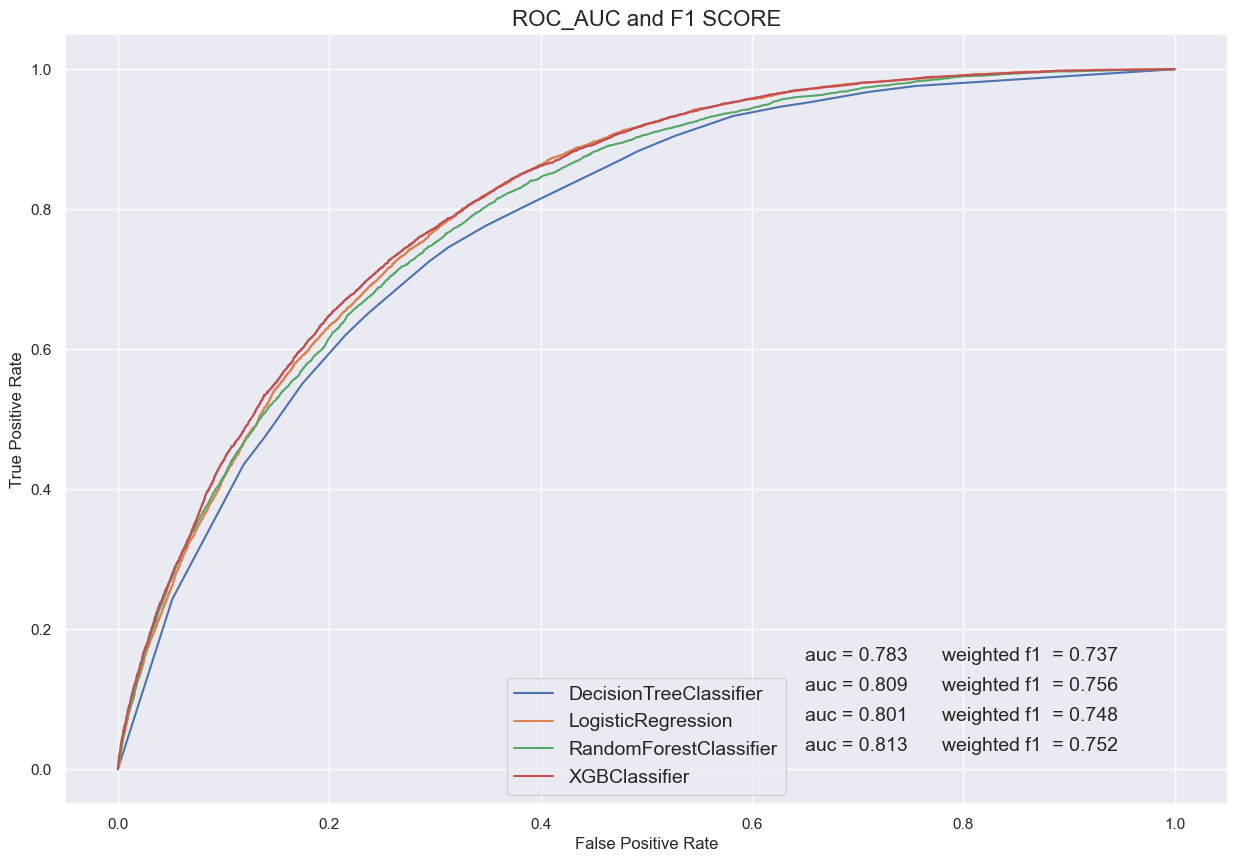

In [42]:
models = [modelDT, modelLR, modelRF, modelXGB]
final_results = []

fig, ax = plt.subplots(figsize=(15, 10))
delta = 0

for model in models:

    yTestpredProb_ = model.predict_proba(dfTest)[:,1]
    yTestpred_ = model.predict(dfTest)
    modelName = type(model.named_steps.classifier).__name__
    
    auc = round(roc_auc_score(yTest, yTestpredProb_),3)
    f1Score = round(f1_score(yTest, yTestpred_, average='weighted'),3)
    
    fpr, tpr, _ = roc_curve(yTest.values, yTestpredProb_)
    roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr)
    roc_display1.plot(ax=ax, name=modelName)
    roc_display1.ax_.set_title('ROC_AUC and F1 SCORE', size= 16)
    ax.text(0.65, 0.155 - delta, f'auc = {auc}', size=14 )
    ax.text(0.78, 0.155 - delta, f'weighted f1  = {f1Score}', size=14)
    ax.legend(loc='lower center', prop={'size': 14})
    delta += 0.043
    final_results.append([modelName, auc, f1Score])

In [43]:
pd.DataFrame(final_results, columns=['Model', 'AUC', 'F1-Score']) \
.sort_values(by='AUC', ascending=False) \
.reset_index(drop=True)

,Model,AUC,F1-Score
0,XGBClassifier,0.813,0.752
1,LogisticRegression,0.809,0.756
2,RandomForestClassifier,0.801,0.748
3,DecisionTreeClassifier,0.783,0.737


## Comparing confusion matrices

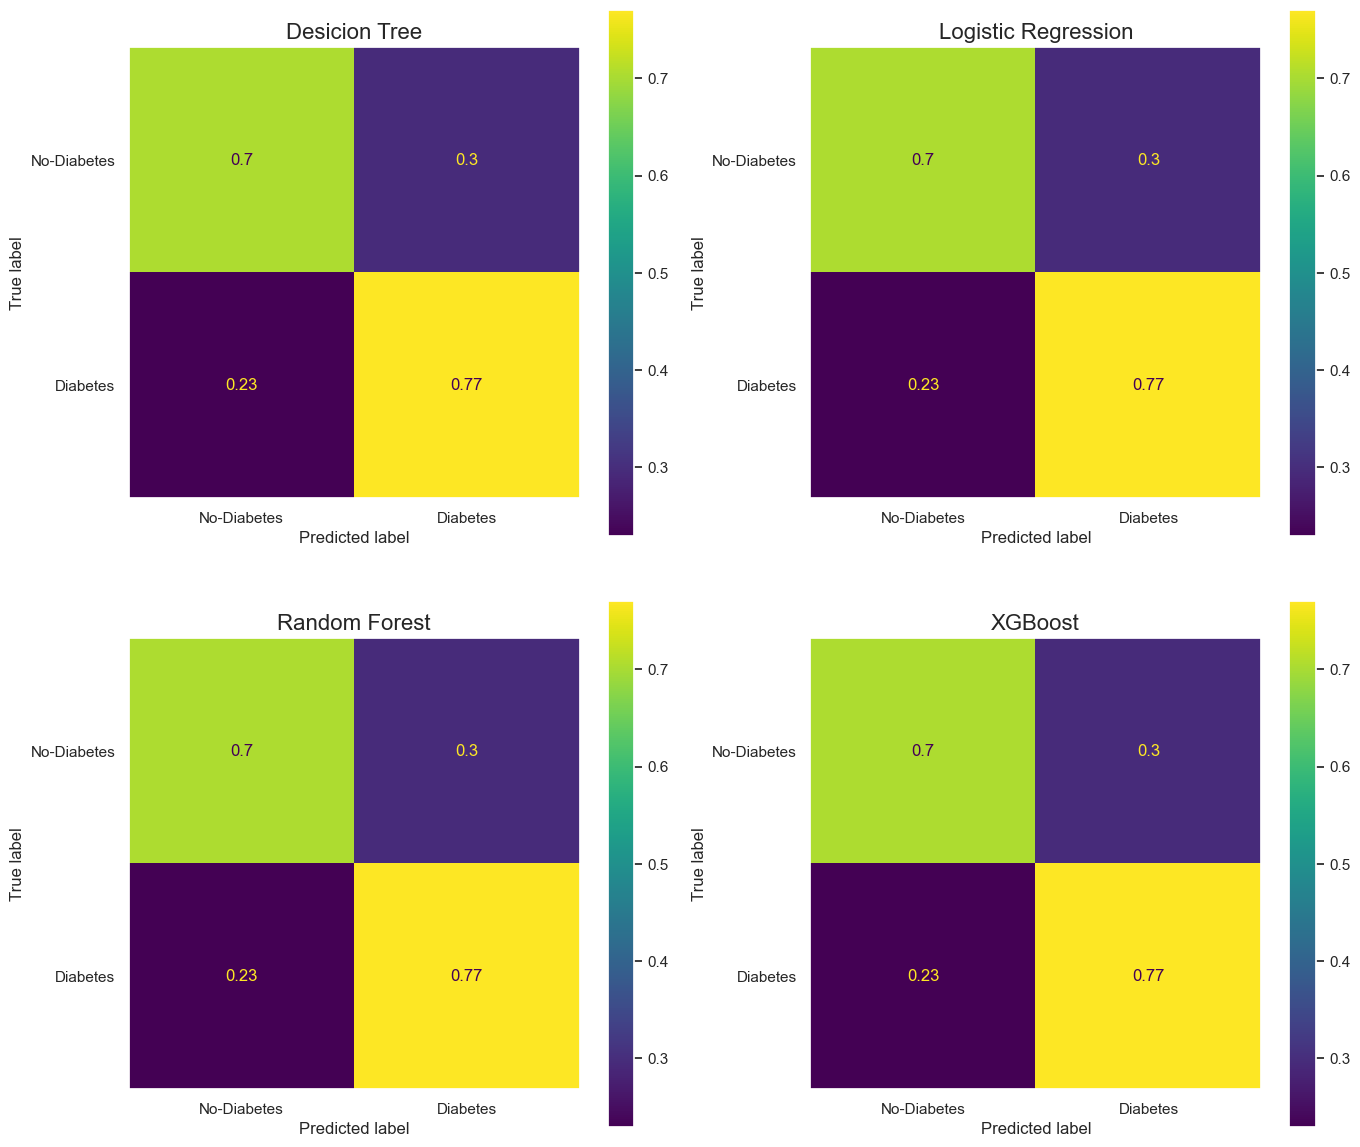

In [44]:
fig, axs = plt.subplots(2,2, figsize=(14, 12))

for (name,matrix), ax in zip(confusion_matrices.items(), axs.ravel()):
    cm_display = ConfusionMatrixDisplay(cm, display_labels=['No-Diabetes', 'Diabetes'])
    cm_display.plot(ax=ax)
    ax.grid(False)
    cm_display.ax_.set_title(name, size=16)

fig.tight_layout()
plt.show()

## FINAL Results:<br><br> The best models are XGBoost and Logistc regression. F1 Score and ROC AUC were used as our metrics.<br><br>

## Saving Models with Pickle

In [45]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

models = [modelDT, modelLR, modelRF, modelXGB]
for model in models:
    modelName = type(model.named_steps.classifier).__name__
    print(f'Saving pickle file for {modelName}')
    outputFile = f'models/{modelName}.bin'
    with open(outputFile, 'wb') as f:
        pickle.dump(model, f)

Saving pickle file for DecisionTreeClassifier
Saving pickle file for LogisticRegression
Saving pickle file for RandomForestClassifier
Saving pickle file for XGBClassifier


In [46]:
import pandas as pd
import pickle
import os

## Testing model predictions

In [47]:
def predict(inputdata):
    
    #Transform inputdata to an inputdataframe
    data = pd.DataFrame(inputdata, index=[1])

    # Mappings
    sex = {'Male':0, 'Female':1}

    binary = {'Yes': 1, 'No': 0}

    education = {
        'Never attended school or only kindergarten' : 1,
        'Elementary school' : 2,
        'Some high school' : 3,
        'High school graduate' : 4,
        'Some college or technical school' : 5,
        'College graduate' : 6
    }

    income = {
        'less than $10,000'  : 1,
        '$10,000 to $15,000' : 2,
        '$15,000 to $20,000' : 3, 
        '$20,000 to $25,000' : 4,
        '$25,000 to $35,000' : 5,
        '$35,000 to $50,000' : 6,
        '$50,000 to $75,000' : 7,
        '$75,000 or  more'   : 8
    }

    genhlth = {
        'Excellent' : 1,
        'Very good' : 2,
        'Good'      : 3,
        'Fair'      : 4,
        'Poor'      : 5
    }

    def getAgeRange(age):

        if 18 <= age <= 24:
            ageRange = 1
        elif 25 <= age <= 29:
            ageRange = 2
        elif 30 <= age <= 34: 
            ageRange = 3
        elif 35 <= age <= 39: 
            ageRange = 4
        elif 40 <= age <= 44:
            ageRange = 5
        elif 45 <= age <= 49:
            ageRange = 6
        elif 50 <= age <= 54:
            ageRange = 7
        elif 55 <= age <= 59:
            ageRange = 8
        elif 60 <= age <= 64:
            ageRange = 9
        elif 65 <= age <= 69:
            ageRange = 10
        elif 70 <= age <= 74:
            ageRange = 11
        elif 75 <= age <= 79:
            ageRange = 12
        elif 80 <= age:
            ageRange = 13
        return ageRange

    # Replace values
    ageRange = getAgeRange(data.age.values)


    data.replace( binary | sex | education | income, inplace=True)
    data.age = ageRange
    data.replace( genhlth, inplace=True )

    # get models from folder and load models to a dictionary
    path = 'models/'
    files = os.listdir(path)
    models = {}

    for file in files:
        filename = file.split('.')[0]
        with open(path + file, 'rb') as f:
            models[filename] = pickle.load(f)        

    # Make predictions
    for name, model in models.items():
        yProb_ = (model.predict_proba(data)[:,1]*100).round(0)
        yPred_ = model.predict(data)
        print(f'{name:<22} : {int(yProb_[0])} %')# = {yPred_}')


### Two testing examples

#### Likely a negative testing example

In [48]:
inputData = {
    'highbp': 'No',
    'highchol': 'No',
    'cholcheck': 'Yes',
    'bmi': 27,
    'smoker': 'Yes',
    'stroke': 'No',
    'heartdiseaseorattack': 'No',
    'physactivity': 'Yes',
    'hvyalcoholconsump': 'No',
    'genhlth':  'Good',
    'menthlth': 0,
    'physhlth': 0,
    'diffwalk': 'No',
    'sex': 'Male',
    'age': 62,
    'education': 'College graduate',
    'income': '$75,000 or  more'
}

d2={'highbp': 'Yes', 'highchol': 'Yes', 'cholcheck': 'Yes', 'bmi': 27, 'smoker': 'Yes', 'stroke': 'Yes', 'heartdiseaseorattack': 'Yes', 'physactivity': 'Yes', 'hvyalcoholconsump': 'Yes', 'genhlth': 'Very good', 'menthlth': 0, 'physhlth': 0, 'diffwalk': 'Yes', 'sex': 'Male', 'age': 62, 'education': 'College graduate', 'income': '$75,000 or  more'}

predict(inputData)

DecisionTreeClassifier : 32 %
LogisticRegression     : 25 %
RandomForestClassifier : 39 %
XGBClassifier          : 38 %


#### Likely a positve testing example

In [49]:
inputData = {
    'highbp': 'Yes',
    'highchol': 'Yes',
    'cholcheck': 'Yes',
    'bmi': 22,
    'smoker': 'No',
    'stroke': 'No',
    'heartdiseaseorattack': 'Yes',
    'physactivity': 'No',
    'hvyalcoholconsump': 'No',
    'genhlth': 'Fair',
    'menthlth': 0,
    'physhlth': 10,
    'diffwalk': 'No',
    'sex': 'Male',
    'age': 52,
    'education': 'High school graduate',
    'income': 'less than $10,000'
}

predict(inputData)

DecisionTreeClassifier : 68 %
LogisticRegression     : 66 %
RandomForestClassifier : 73 %
XGBClassifier          : 71 %
